In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [17]:
df = pd.read_csv('../weather.csv', parse_dates=['datetime'], index_col='datetime')

In [18]:
df.shape

(175320, 5)

In [19]:
df.values


array([[   5.75,  336.01,    0.  ,   16.85, -999.  ],
       [   6.2 ,  342.02,    0.  ,   16.21, -999.  ],
       [   6.  ,  349.8 ,    0.  ,   15.55, -999.  ],
       ...,
       [   5.39,  320.77,    0.  ,   20.14, -999.  ],
       [   5.61,  324.76,    0.  ,   19.69, -999.  ],
       [   5.91,  329.57,    0.  ,   19.2 , -999.  ]])

In [47]:
df_sample = df.loc['2021-01-01 00:00:00':]

In [50]:
df_sample.tail()

,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,
2023-12-31 19:00:00,4.99,323.02,0.0,21.12,-999.0
2023-12-31 20:00:00,5.25,320.25,0.0,20.61,-999.0
2023-12-31 21:00:00,5.39,320.77,0.0,20.14,-999.0
2023-12-31 22:00:00,5.61,324.76,0.0,19.69,-999.0
2023-12-31 23:00:00,5.91,329.57,0.0,19.20,-999.0


In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, n_steps_in, n_steps_out):
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out
        self.sequences = sequences
        self.X, self.y = self.split_sequences()

    def split_sequences(self):
        X, y = [], []
        for i in range(len(self.sequences)):
            end_ix = i + self.n_steps_in
            out_end_ix = end_ix + self.n_steps_out - 1
            if out_end_ix > len(self.sequences):
                break
            seq_x = self.sequences[i:end_ix, 1:5]
            seq_y = self.sequences[end_ix-1:out_end_ix, 0]
            X.append(seq_x)
            y.append(seq_y)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [54]:
df_sample

,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,
2021-01-01 00:00:00,4.91,347.42,0.0,17.58,-999.0
2021-01-01 01:00:00,5.06,352.82,0.0,17.02,-999.0
2021-01-01 02:00:00,5.21,355.27,0.0,16.51,-999.0
2021-01-01 03:00:00,4.98,357.93,0.0,16.05,-999.0
2021-01-01 04:00:00,4.38,1.43,0.0,15.72,-999.0
...,...,...,...,...,...
2023-12-31 19:00:00,4.99,323.02,0.0,21.12,-999.0
2023-12-31 20:00:00,5.25,320.25,0.0,20.61,-999.0
2023-12-31 21:00:00,5.39,320.77,0.0,20.14,-999.0


In [55]:
# train_df = df.loc[:'2021-12-31 23:00:00']
# val_df   = df.loc['2022-01-01 00:00:00':'2022-12-31 23:00:00']
# test_df  = df.loc['2023-01-01 00:00:00':]

train_df = df_sample.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00']
val_df   = df.loc['2022-01-01 00:00:00':'2022-12-31 23:00:00']
test_df  = df.loc['2023-01-01 00:00:00':]


In [56]:
train_df.head()
train_df.tail()

,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,
2021-12-31 19:00:00,6.47,333.22,0.0,20.08,-999.0
2021-12-31 20:00:00,6.48,335.94,0.0,19.61,-999.0
2021-12-31 21:00:00,6.35,339.34,0.0,19.15,-999.0
2021-12-31 22:00:00,6.13,342.12,0.0,18.70,-999.0
2021-12-31 23:00:00,5.95,343.59,0.0,18.23,-999.0


In [57]:
test_df.head()
test_df.tail()

,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,
2023-12-31 19:00:00,4.99,323.02,0.0,21.12,-999.0
2023-12-31 20:00:00,5.25,320.25,0.0,20.61,-999.0
2023-12-31 21:00:00,5.39,320.77,0.0,20.14,-999.0
2023-12-31 22:00:00,5.61,324.76,0.0,19.69,-999.0
2023-12-31 23:00:00,5.91,329.57,0.0,19.20,-999.0


In [58]:
train_df.iloc[:, 0]

datetime
2021-01-01 00:00:00    4.91
2021-01-01 01:00:00    5.06
2021-01-01 02:00:00    5.21
2021-01-01 03:00:00    4.98
2021-01-01 04:00:00    4.38
                       ... 
2021-12-31 19:00:00    6.47
2021-12-31 20:00:00    6.48
2021-12-31 21:00:00    6.35
2021-12-31 22:00:00    6.13
2021-12-31 23:00:00    5.95
Name: Wind Speed, Length: 8760, dtype: float64

In [61]:
train_df.iloc[:, 1:5].shape

(8760, 4)

In [66]:
train_df.iloc[:, 0:1].shape

(8760, 1)

In [67]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Separate features and target
X_train = train_df.iloc[:, 1:5]
y_train = train_df.iloc[:, 0:1]

# Fit scalers
X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)

# Transform val and test using same scaler (IMPORTANT)
X_val_scaled = feature_scaler.transform(val_df.iloc[:, 1:5])
y_val_scaled = target_scaler.transform(val_df.iloc[:, 0:1])

X_test_scaled = feature_scaler.transform(test_df.iloc[:, 1:5])
y_test_scaled = target_scaler.transform(test_df.iloc[:, 0:1])

# Combine back into arrays
train_scaled = np.hstack([X_train_scaled, y_train_scaled])
val_scaled   = np.hstack([X_val_scaled, y_val_scaled])
test_scaled  = np.hstack([X_test_scaled, y_test_scaled])


In [77]:
from torch.utils.data import DataLoader

n_steps_in = 720
n_steps_out = 360
batch_size = 32

train_dataset = TimeSeriesDataset(train_scaled, n_steps_in, n_steps_out)
val_dataset   = TimeSeriesDataset(val_scaled, n_steps_in, n_steps_out)
test_dataset  = TimeSeriesDataset(test_scaled, n_steps_in, n_steps_out)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [78]:
print("Train dataset length", train_dataset.__len__())
print("Train dataset length", val_dataset.__len__())
print("Test dataset length", test_dataset.__len__())

Train dataset length 7682
Train dataset length 7682
Test dataset length 7682


In [80]:
train_dataset[0]

(tensor([[-0.7343, -2.1707, -1.0456, -0.0261],
         [-0.7343, -2.3094, -1.0456,  0.0312],
         [-0.7343, -2.4358, -1.0456,  0.0885],
         ...,
         [-0.7343, -1.9181, -1.0456, -0.0529],
         [-0.7343, -2.0345, -1.0456, -0.0758],
         [-0.7343, -2.1757, -1.0456, -0.0911]]),
 tensor([-1.8564, -1.8192, -1.7944, -1.7692, -1.7776, -1.7994, -1.8161, -1.8382,
         -1.8699, -1.9474, -2.0190,  1.4660,  1.3471,  1.2886,  1.2695,  1.2708,
          1.2614,  1.2572,  1.2689,  1.2835,  1.2946,  1.2949,  1.3112,  1.3423,
          1.3790,  1.4303,  1.4919, -2.0178, -1.9638, -1.9279, -1.9014, -1.8991,
         -1.9336, -2.0181,  1.4789,  1.4429,  1.4199,  1.3917,  1.3652,  1.3480,
          1.3317,  1.3016,  1.2519,  1.2059,  1.1758,  1.1661,  1.1834,  1.2265,
          1.2988,  1.3871,  1.4736, -2.0300, -1.9674, -1.9230, -1.8909, -1.8831,
         -1.9178, -2.0303,  1.4300,  1.4072,  1.3867,  1.3646,  1.3481,  1.3384,
          1.3252,  1.2984,  1.2764,  1.2638,  1.2574, 

In [81]:
test_dataset[-1]

(tensor([[-0.7343, -0.4791, -1.0456,  0.0579],
         [-0.7343, -0.4915, -1.0456, -0.0376],
         [-0.7343, -0.5063, -1.0456,  0.0541],
         ...,
         [-0.7343, -1.5416, -1.0456, -0.7293],
         [-0.7343, -1.6382, -1.0456, -0.6949],
         [-0.7343, -1.7571, -1.0456, -0.5917]]),
 tensor([ 1.5045,  1.4872,  1.4924,  1.5233, -2.0287, -1.9904, -1.9464, -1.9108,
         -1.8819, -1.9053, -1.9615, -2.0188,  1.5260,  1.4941,  1.4734,  1.4493,
          1.4128,  1.3517,  1.3059,  1.2842,  1.3026,  1.3397,  1.3842,  1.4492,
          1.4984,  1.5137,  1.5199,  1.5314,  1.5503, -2.0244, -2.0303, -2.0279,
         -2.0011, -1.9853, -2.0137,  1.5043,  1.3835,  1.2590,  1.1950,  1.2028,
          1.2199,  1.2072,  1.1909,  1.1810,  1.1953,  1.2287,  1.2573,  1.2860,
          1.3262,  1.3600,  1.3874,  1.4147,  1.4545,  1.5087, -2.0256, -1.9994,
         -2.0057,  1.5422,  1.4933,  1.4254,  1.3808,  1.3605,  1.3363,  1.3128,
          1.2908,  1.2693,  1.2655,  1.2758,  1.3088, 

In [82]:
print(val_dataset[0])

(tensor([[-0.7343, -2.1361, -1.0456,  0.3522],
        [-0.7343, -2.2673, -1.0456,  0.4210],
        [-0.7343, -2.3565, -1.0456,  0.4974],
        ...,
        [-0.7343, -2.1460, -1.0456,  0.0541],
        [-0.7343, -2.2302, -1.0456,  0.1000],
        [-0.7343, -2.3045, -1.0456,  0.0885]]), tensor([ 1.3810,  1.4293,  1.4927, -2.0178, -1.9141, -1.7904, -1.6820, -1.5606,
        -1.4223, -1.3767, -1.5290, -1.9262,  1.3547,  1.2049,  1.1418,  1.1486,
         1.1416,  1.0972,  1.0311,  0.9731, -0.6761, -0.7055, -0.7085, -0.6829,
        -0.6443, -0.6153, -0.5974, -0.5949, -0.5701, -0.5204, -0.4800, -0.4594,
        -0.4112, -0.3019, -0.2010, -0.1224, -0.0627, -0.0169,  0.0113,  0.0055,
        -0.0340, -0.1294, -0.2346, -0.2785, -0.2760, -0.2438, -0.1909, -0.0665,
         0.1071,  0.2573,  0.3857,  0.4815,  0.6278,  0.8030,  0.9213,  0.9655,
         0.6693,  0.3647,  0.4254,  0.4625,  0.4708,  0.5038,  0.5626,  0.6207,
         0.6122,  0.4627, -0.0261, -0.4232, -0.5736, -0.6678, -0.759

In [83]:
# Check the length
print(len(train_dataset))

# Check one sample
X_sample, y_sample = train_dataset[0]
print("Input sequence shape:", X_sample.shape)
print("Output sequence shape:", y_sample.shape)

# Optional: print actual values
print("Input sample (X):", X_sample)
print("Output sample (y):", y_sample)

7682
Input sequence shape: torch.Size([720, 4])
Output sequence shape: torch.Size([360])
Input sample (X): tensor([[-0.7343, -2.1707, -1.0456, -0.0261],
        [-0.7343, -2.3094, -1.0456,  0.0312],
        [-0.7343, -2.4358, -1.0456,  0.0885],
        ...,
        [-0.7343, -1.9181, -1.0456, -0.0529],
        [-0.7343, -2.0345, -1.0456, -0.0758],
        [-0.7343, -2.1757, -1.0456, -0.0911]])
Output sample (y): tensor([-1.8564, -1.8192, -1.7944, -1.7692, -1.7776, -1.7994, -1.8161, -1.8382,
        -1.8699, -1.9474, -2.0190,  1.4660,  1.3471,  1.2886,  1.2695,  1.2708,
         1.2614,  1.2572,  1.2689,  1.2835,  1.2946,  1.2949,  1.3112,  1.3423,
         1.3790,  1.4303,  1.4919, -2.0178, -1.9638, -1.9279, -1.9014, -1.8991,
        -1.9336, -2.0181,  1.4789,  1.4429,  1.4199,  1.3917,  1.3652,  1.3480,
         1.3317,  1.3016,  1.2519,  1.2059,  1.1758,  1.1661,  1.1834,  1.2265,
         1.2988,  1.3871,  1.4736, -2.0300, -1.9674, -1.9230, -1.8909, -1.8831,
        -1.9178, -2.0303

In [84]:
# Check the length
print(len(val_dataset))

# Check one sample
X_sample, y_sample = val_dataset[0]
print("Input sequence shape:", X_sample.shape)
print("Output sequence shape:", y_sample.shape)

# Optional: print actual values
print("Input sample (X):", X_sample)
print("Output sample (y):", y_sample)

7682
Input sequence shape: torch.Size([720, 4])
Output sequence shape: torch.Size([360])
Input sample (X): tensor([[-0.7343, -2.1361, -1.0456,  0.3522],
        [-0.7343, -2.2673, -1.0456,  0.4210],
        [-0.7343, -2.3565, -1.0456,  0.4974],
        ...,
        [-0.7343, -2.1460, -1.0456,  0.0541],
        [-0.7343, -2.2302, -1.0456,  0.1000],
        [-0.7343, -2.3045, -1.0456,  0.0885]])
Output sample (y): tensor([ 1.3810,  1.4293,  1.4927, -2.0178, -1.9141, -1.7904, -1.6820, -1.5606,
        -1.4223, -1.3767, -1.5290, -1.9262,  1.3547,  1.2049,  1.1418,  1.1486,
         1.1416,  1.0972,  1.0311,  0.9731, -0.6761, -0.7055, -0.7085, -0.6829,
        -0.6443, -0.6153, -0.5974, -0.5949, -0.5701, -0.5204, -0.4800, -0.4594,
        -0.4112, -0.3019, -0.2010, -0.1224, -0.0627, -0.0169,  0.0113,  0.0055,
        -0.0340, -0.1294, -0.2346, -0.2785, -0.2760, -0.2438, -0.1909, -0.0665,
         0.1071,  0.2573,  0.3857,  0.4815,  0.6278,  0.8030,  0.9213,  0.9655,
         0.6693,  0.3647

In [85]:
# Check the length
print(len(test_dataset))

# Check one sample
X_sample, y_sample = test_dataset[-1]
print("Input sequence shape:", X_sample.shape)
print("Output sequence shape:", y_sample.shape)

# Optional: print actual values
print("Input sample (X):", X_sample)
print("Output sample (y):", y_sample)

7682
Input sequence shape: torch.Size([720, 4])
Output sequence shape: torch.Size([360])
Input sample (X): tensor([[-0.7343, -0.4791, -1.0456,  0.0579],
        [-0.7343, -0.4915, -1.0456, -0.0376],
        [-0.7343, -0.5063, -1.0456,  0.0541],
        ...,
        [-0.7343, -1.5416, -1.0456, -0.7293],
        [-0.7343, -1.6382, -1.0456, -0.6949],
        [-0.7343, -1.7571, -1.0456, -0.5917]])
Output sample (y): tensor([ 1.5045,  1.4872,  1.4924,  1.5233, -2.0287, -1.9904, -1.9464, -1.9108,
        -1.8819, -1.9053, -1.9615, -2.0188,  1.5260,  1.4941,  1.4734,  1.4493,
         1.4128,  1.3517,  1.3059,  1.2842,  1.3026,  1.3397,  1.3842,  1.4492,
         1.4984,  1.5137,  1.5199,  1.5314,  1.5503, -2.0244, -2.0303, -2.0279,
        -2.0011, -1.9853, -2.0137,  1.5043,  1.3835,  1.2590,  1.1950,  1.2028,
         1.2199,  1.2072,  1.1909,  1.1810,  1.1953,  1.2287,  1.2573,  1.2860,
         1.3262,  1.3600,  1.3874,  1.4147,  1.4545,  1.5087, -2.0256, -1.9994,
        -2.0057,  1.5422

In [86]:
# Get one batch from DataLoader
for X_batch, y_batch in train_loader:
    print("Batch Input shape:", X_batch.shape)
    print(X_batch)
    print("Batch Output shape:", y_batch.shape)
    print(y_batch)
    
    n_steps_in = X_batch.shape[1]
    n_features = X_batch.shape[2]
    n_steps_out = y_batch.shape[1]
    
    print(n_steps_in, n_features, n_steps_out)
    break


Batch Input shape: torch.Size([32, 720, 4])
tensor([[[-7.3426e-01, -2.1707e+00, -1.0456e+00, -2.6146e-02],
         [-7.3426e-01, -2.3094e+00, -1.0456e+00,  3.1179e-02],
         [-7.3426e-01, -2.4358e+00, -1.0456e+00,  8.8503e-02],
         ...,
         [-7.3426e-01, -1.9181e+00, -1.0456e+00, -5.2897e-02],
         [-7.3426e-01, -2.0345e+00, -1.0456e+00, -7.5827e-02],
         [-7.3426e-01, -2.1757e+00, -1.0456e+00, -9.1114e-02]],

        [[-7.3426e-01, -2.3094e+00, -1.0456e+00,  3.1179e-02],
         [-7.3426e-01, -2.4358e+00, -1.0456e+00,  8.8503e-02],
         [-7.3426e-01, -2.5497e+00, -1.0456e+00,  6.0553e-04],
         ...,
         [-7.3426e-01, -2.0345e+00, -1.0456e+00, -7.5827e-02],
         [-7.3426e-01, -2.1757e+00, -1.0456e+00, -9.1114e-02],
         [-7.3426e-01, -2.3466e+00, -1.0456e+00, -6.8184e-02]],

        [[-7.3426e-01, -2.4358e+00, -1.0456e+00,  8.8503e-02],
         [-7.3426e-01, -2.5497e+00, -1.0456e+00,  6.0553e-04],
         [-7.3426e-01, -2.6314e+00, -1.045

In [87]:
for X_batch, y_batch in val_loader:
    print("Batch Input shape:", X_batch.shape)
    print(X_batch)
    print("Batch Output shape:", y_batch.shape)
    print(y_batch)
    
    n_steps_in = X_batch.shape[1]
    n_features = X_batch.shape[2]
    n_steps_out = y_batch.shape[1]
    
    print(n_steps_in, n_features, n_steps_out)
    break

Batch Input shape: torch.Size([32, 720, 4])
tensor([[[-0.7343, -2.1361, -1.0456,  0.3522],
         [-0.7343, -2.2673, -1.0456,  0.4210],
         [-0.7343, -2.3565, -1.0456,  0.4974],
         ...,
         [-0.7343, -2.1460, -1.0456,  0.0541],
         [-0.7343, -2.2302, -1.0456,  0.1000],
         [-0.7343, -2.3045, -1.0456,  0.0885]],

        [[-0.7343, -2.2673, -1.0456,  0.4210],
         [-0.7343, -2.3565, -1.0456,  0.4974],
         [-0.7343, -2.4234, -1.0456,  0.5203],
         ...,
         [-0.7343, -2.2302, -1.0456,  0.1000],
         [-0.7343, -2.3045, -1.0456,  0.0885],
         [-0.7343, -2.3763, -1.0456,  0.0121]],

        [[-0.7343, -2.3565, -1.0456,  0.4974],
         [-0.7343, -2.4234, -1.0456,  0.5203],
         [-0.7343, -2.4878, -1.0456,  0.4286],
         ...,
         [-0.7343, -2.3045, -1.0456,  0.0885],
         [-0.7343, -2.3763, -1.0456,  0.0121],
         [-0.7343, -2.4432, -1.0456, -0.1446]],

        ...,

        [[-0.7343, -2.5348, -1.0456,  0.2681],
 

In [88]:
for X_batch, y_batch in test_loader:
    print("Batch Input shape:", X_batch.shape)
    print(X_batch)
    print("Batch Output shape:", y_batch.shape)
    print(y_batch)
    
    n_steps_in = X_batch.shape[1]
    n_features = X_batch.shape[2]
    n_steps_out = y_batch.shape[1]
    
    print(n_steps_in, n_features, n_steps_out)
    break

Batch Input shape: torch.Size([32, 720, 4])
tensor([[[-0.7343, -1.9627, -1.0456, -0.2478],
         [-0.7343, -2.0692, -1.0456, -0.1293],
         [-0.7343, -2.1584, -1.0456, -0.0873],
         ...,
         [-0.7343, -1.1255, -1.0456, -0.6605],
         [-0.7343, -1.1850, -1.0456, -0.7026],
         [-0.7343, -1.2593, -1.0456, -0.7446]],

        [[-0.7343, -2.0692, -1.0456, -0.1293],
         [-0.7343, -2.1584, -1.0456, -0.0873],
         [-0.7343, -2.2252, -1.0456, -0.1523],
         ...,
         [-0.7343, -1.1850, -1.0456, -0.7026],
         [-0.7343, -1.2593, -1.0456, -0.7446],
         [-0.7343, -1.3212, -1.0456, -0.8096]],

        [[-0.7343, -2.1584, -1.0456, -0.0873],
         [-0.7343, -2.2252, -1.0456, -0.1523],
         [-0.7343, -2.2847, -1.0456, -0.2440],
         ...,
         [-0.7343, -1.2593, -1.0456, -0.7446],
         [-0.7343, -1.3212, -1.0456, -0.8096],
         [-0.7343, -1.3881, -1.0456, -0.9013]],

        ...,

        [[-0.7343, -2.3813, -1.0456, -0.0070],
 

In [89]:
import torch
import torch.nn as nn

class LSTMForecastModel(nn.Module):
    def __init__(self, n_features, n_steps_in, n_steps_out, hidden_dim=100):
        super(LSTMForecastModel, self).__init__()
        self.n_steps_out = n_steps_out
        
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, n_steps_out)

    def forward(self, x):
        # x: [batch_size, seq_len, n_features]
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Take last time step's output from second LSTM
        x = x[:, -1, :]  # shape: [batch_size, hidden_dim]
        
        # Project to n_steps_out
        out = self.fc(x)  # shape: [batch_size, n_steps_out]
        return out


In [ ]:
# model = LSTMForecastModel(n_features=n_features, 
#                           n_steps_in=n_steps_in, 
#                           n_steps_out=n_steps_out)

# # Check output shape
# with torch.no_grad():
#     y_pred = model(X_batch)  # should be [batch_size, n_steps_out]
#     print("Predicted value: ", y_pred)
#     print("Predicted shape:", y_pred.shape)

Predicted value:  tensor([[ 0.0997, -0.1550]])
Predicted shape: torch.Size([1, 2])


In [ ]:
# y_pred.shape == y_batch.shape  # Both should be [batch_size, n_steps_out]


True

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import mean_absolute_error
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, patience=5):
    model.to(device)
    best_val_loss = float('inf')
    best_model_path = "best_model.pth"
    trigger_times = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds = model(X_val)
                loss = criterion(preds, y_val)
                val_loss += loss.item() * X_val.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), best_model_path)
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(best_model_path))
    
    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss over Epochs")
    plt.show()

    return model

Epoch 1/30 - Train Loss: 0.8132, Val Loss: 0.7850
Epoch 2/30 - Train Loss: 0.7808, Val Loss: 0.8087
Epoch 3/30 - Train Loss: 0.7865, Val Loss: 0.8149
Epoch 4/30 - Train Loss: 0.7962, Val Loss: 0.8122
Epoch 5/30 - Train Loss: 0.8017, Val Loss: 0.7784
Epoch 6/30 - Train Loss: 0.7891, Val Loss: 0.7816
Epoch 7/30 - Train Loss: 0.7879, Val Loss: 0.7669
Epoch 8/30 - Train Loss: 0.7847, Val Loss: 0.7684
Epoch 9/30 - Train Loss: 0.7802, Val Loss: 0.7766
Epoch 10/30 - Train Loss: 0.7785, Val Loss: 0.7609
Epoch 11/30 - Train Loss: 0.7762, Val Loss: 0.7407
Epoch 12/30 - Train Loss: 0.7697, Val Loss: 0.7313
Epoch 13/30 - Train Loss: 0.7685, Val Loss: 0.7327
Epoch 14/30 - Train Loss: 0.7645, Val Loss: 0.7218
Epoch 15/30 - Train Loss: 0.7626, Val Loss: 0.7200
Epoch 16/30 - Train Loss: 0.7578, Val Loss: 0.7279
Epoch 17/30 - Train Loss: 0.7538, Val Loss: 0.7306
Epoch 18/30 - Train Loss: 0.7509, Val Loss: 0.7294
Epoch 19/30 - Train Loss: 0.7489, Val Loss: 0.7317
Epoch 20/30 - Train Loss: 0.7487, Val Lo

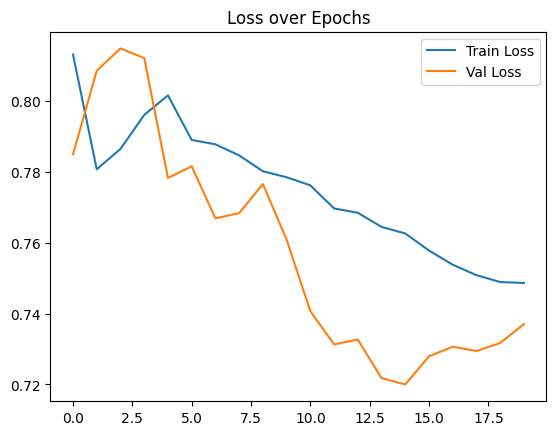

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMForecastModel(n_features=n_features,n_steps_in=n_steps_in, n_steps_out=n_steps_out)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

model = train_model(model, train_loader, val_loader, num_epochs=30, criterion=criterion, optimizer=optimizer, device=device)

In [93]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device).float()
            y = y.to(device).float()

            preds = model(X)
            loss = criterion(preds, y)
            total_loss += loss.item() * X.size(0)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    mae = mean_absolute_error(targets, preds)

    print(f"Evaluation - Loss: {avg_loss:.4f}, MAE (≈ accuracy): {mae:.4f}")
    return avg_loss, mae


In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
model.eval()
preds = []
targets = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        output = model(X_test).cpu().numpy()
        target = y_test.numpy()

        preds.append(output)
        targets.append(target)

preds = np.concatenate(preds)
targets = np.concatenate(targets)

if preds.ndim == 1:
    preds = preds.reshape(-1, 1)
if targets.ndim == 1:
    targets = targets.reshape(-1, 1)

# Inverse scale
preds_unscaled = target_scaler.inverse_transform(preds)[:, 0]
targets_unscaled = target_scaler.inverse_transform(targets)[:, 0]

mae = mean_absolute_error(targets_unscaled, preds_unscaled)
rmse = np.sqrt(mean_squared_error(targets_unscaled, preds_unscaled))

print(f"\n✅ Final Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")


✅ Final Test MAE: 1.743, RMSE: 2.302


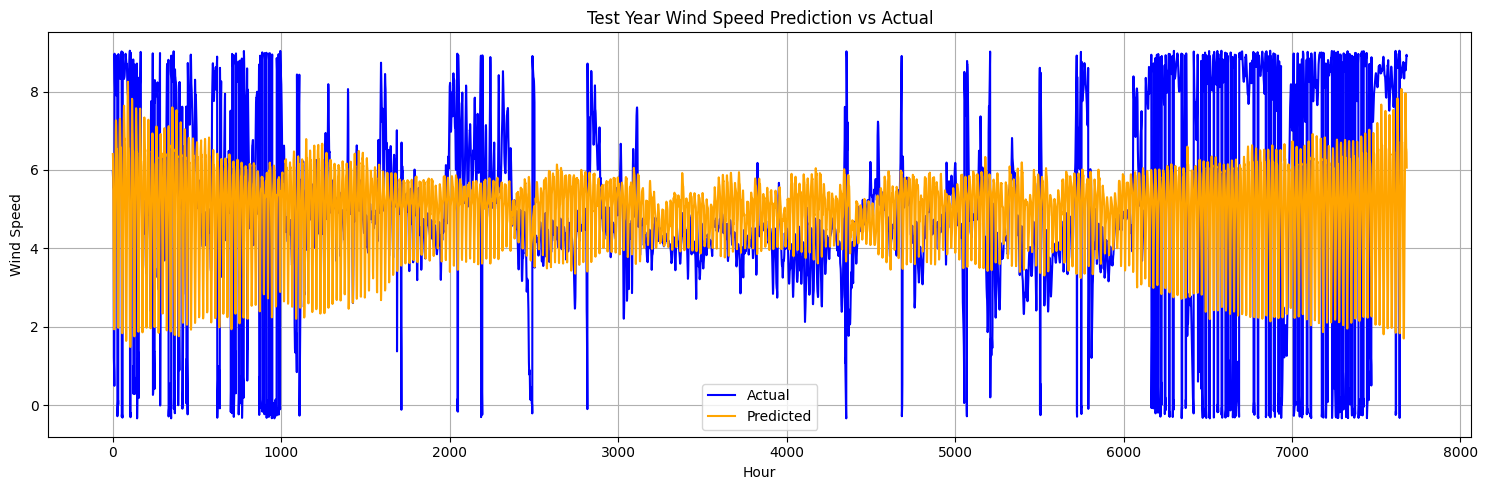

In [97]:
plt.figure(figsize=(15, 5))
plt.plot(targets_unscaled, label='Actual', color='blue')
plt.plot(preds_unscaled, label='Predicted', color='orange')
plt.title('Test Year Wind Speed Prediction vs Actual')
plt.xlabel('Hour')
plt.ylabel('Wind Speed')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()